In [1]:
#Import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import itertools
from scipy import stats

In [2]:
#Load Rental Data - Note there are some missing values in some columns, but I've filtered out as many as 
#I'm willing to drop from this dataset in lieu of losing other important data points
rental_data = pd.read_csv('C:/datascience/springboard/projects/Rental Property ROI/data/Rental Data CF.csv', parse_dates=['date'], infer_datetime_format=True)
rental_data.info()
rental_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302185 entries, 0 to 302184
Data columns (total 53 columns):
RegionName                                      302185 non-null object
index                                           302185 non-null int64
RegionID                                        302185 non-null int64
City                                            302185 non-null object
State                                           302185 non-null object
Metro                                           302120 non-null object
CountyName                                      302185 non-null object
SizeRank                                        302185 non-null float64
date                                            302185 non-null datetime64[ns]
Neighborhood_MedianValuePerSqft_AllHomes        302185 non-null float64
Neighborhood_PriceToRentRatio_AllHomes          299102 non-null float64
Neighborhood_Zhvi_3bedroom                      241610 non-null float64
Neighborhood_Zhvi_4bedroom 

,RegionName,index,RegionID,City,State,Metro,CountyName,SizeRank,date,Neighborhood_MedianValuePerSqft_AllHomes,...,taxes,net_cf,gross_sale_proceeds,gain_loss,dep_recap,cap_gain,capgl_tax,after_tax_proceeds,cfs_plus_sale,cf_irr
0,Chestnut Ridge,0,4083,Ramapo,NY,New York_Newark_Jersey City,Rockland County,1761.0,2014-01-31,211.0,...,-556.710963,150.099679,361950.0,-17895.454545,0.0,-17895.454545,-4473.863636,62047.857574,62197.957253,-0.998030
1,Chestnut Ridge,21,4083,Ramapo,NY,New York_Newark_Jersey City,Rockland County,1761.0,2014-02-28,211.0,...,-561.094514,148.864316,364800.0,-13890.909091,0.0,-13890.909091,-3472.727273,64322.197876,64471.062192,-0.954805
2,Chestnut Ridge,42,4083,Ramapo,NY,New York_Newark_Jersey City,Rockland County,1761.0,2014-03-31,212.0,...,-566.208657,153.278298,368125.0,-9411.363636,0.0,-9411.363636,-2352.840909,66954.276090,67107.554388,-0.867925
3,Chestnut Ridge,63,4083,Ramapo,NY,New York_Newark_Jersey City,Rockland County,1761.0,2014-04-30,214.0,...,-569.277143,166.027201,370120.0,-6261.818182,0.0,-6261.818182,-1565.454545,68590.347420,68756.374621,-0.770655
4,Chestnut Ridge,84,4083,Ramapo,NY,New York_Newark_Jersey City,Rockland County,1761.0,2014-05-30,214.0,...,-569.715498,159.067149,370405.0,-4822.272727,0.0,-4822.272727,-1205.568182,68945.417088,69104.484237,-0.686064


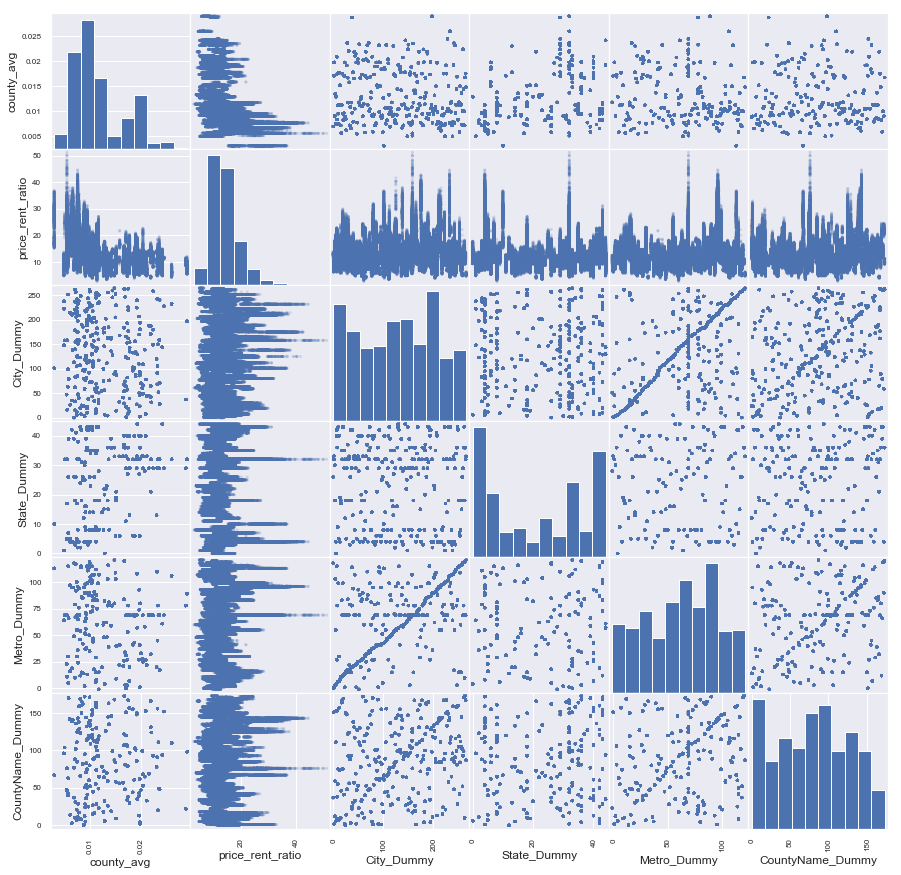

In [3]:
#Do efficient EDA for selected columns to look for any patterns in which to help structure hypothesis
matrix_df = rental_data[['City','State','Metro','CountyName','county_avg','Neighborhood_PriceToRentRatio_AllHomes']]
matrix_df = matrix_df.rename(columns={'Neighborhood_PriceToRentRatio_AllHomes':'price_rent_ratio'})

#Create integer dummy codes for all string columns, so scatter matrix automatically plots data. This runs slow due to 
#complexity of some variables
for i in matrix_df.columns:
    if isinstance(matrix_df[i].iloc[0], (float, int)) == True:
        continue
    else:      
        matrix_df.loc[:, i] = matrix_df[i].astype('category')
        matrix_df.loc[:, '%s_Dummy' % i] = matrix_df[i].cat.codes

#Create Scatterplot matrix 
pd.plotting.scatter_matrix(matrix_df, alpha=0.2, figsize=(15, 15))
plt.show()

Quick oberservations from EDA using scatter-plot matrix

1) Clear differences in price-to-rent ratios by state, city, metro, and county. Start from least to most granular (i.e. state to neighborhood). Have these relationships held historically?
2) As property taxes become lower, dispersion of price-to-rent ratios increase. Likely because there are more observations.
3) As observed in distribution of price-to-rent ratios, should cut be made to remove higher ratios (i.e. less attractive markets)? 

Given the observations of varying price-to-rent ratios, I'd suspect that we'd see differences in net cash flow for an "average" property when comparing states. Given this hypothesis, we'd need to calculate net cash flow's across all regions, which incorporates expenses (mortgage, maintenance, mgmt fees, etc.). After calculating these values, we will test the following hypothesis:

Ho: Net cash flows materially differ across states<br>
Ha: Net cash flows don't materially differ across states<br>

We will define statistical significance by observing if at least 25% of regions net cash flows's differ from other regions with 99% confidence.  

In [4]:
rental_data_subset = rental_data.set_index('State')
rental_data_subset = rental_data_subset.loc[['CA', 'CO', 'DC', 'FL', 'GA', 'MN', 'MS', 'TN']]
rental_data_subset = rental_data_subset.groupby('RegionID').filter(lambda x: x['net_cf'].mean() >= 100)
rental_data_subset = rental_data_subset.groupby('RegionID').filter(lambda x: x['Neighborhood_Zhvi_SingleFamilyResidence'].tail(1) <= 300000)

#Populate list of differences between statistics for all possible combinations (mean, std)
#Create empty list for each combination metric
mean_diff = []
std_diff = []
feature_combo = []

#Loop through df and perform desired calculation for each column 
def feature_comp(df, feature_col):     
    
    #Get rollup statistics for desired feature (mean, std, samp_var, count
    df = df.sort_values('date') #Redundant, but ensures proper sort for 'last' value
    df_agg = df.groupby(feature_col)['net_cf'].agg(['mean','std','count']).reset_index()
    df_agg['samp_var'] = df_agg['std'] **2 / 92 #df_agg['count'] replaced state counts with region counts (92 months)
    
    #Iterate through all combinations of given feature calculating differences for mean, std 
    for idx, col in enumerate(df_agg.columns): 
        for a, b in itertools.combinations(df_agg[col], 2):
            if col == feature_col:
                feature_combo.append((a, b))
            elif col == str('mean'):
                mu_diff = a - b 
                mean_diff.append(mu_diff)
            elif col == str('samp_var'):
                sigma_diff = float(np.sqrt([a + b])) 
                std_diff.append(sigma_diff)
            else:
                continue
    return df_agg

#Input desired df and feature_col
state_stats = feature_comp(rental_data_subset, 'State') #We also save function call to preserve df_agg, which has feature_col summary
                
#Form new df for each combination, then calculate z_score, p_value, and determine is Ho can be rejected.
feature_df = pd.DataFrame({'feature_combo':feature_combo, 'mean_diff':mean_diff, 'std_diff':std_diff})  
feature_df.loc[:, 'z_score'] = abs(feature_df['mean_diff'] / feature_df['std_diff'])
feature_df.loc[:, 'p_value'] = feature_df['z_score'].apply(lambda x: round(stats.norm.sf(abs(x)),4)*2) #Two-tailed
feature_df.loc[:, 'reject_null'] = feature_df['p_value'].apply(lambda x: 'Yes' if x < 0.01 else 'No') #Significance @ 1%

#print summary of feature_col stats 
state_stats.sort_values('mean', ascending=False)

,State,mean,std,count,samp_var
2,DC,884.198855,70.173386,65,53.525045
4,GA,712.701769,197.707834,260,424.873778
1,CO,641.759798,265.251625,845,764.765482
3,FL,494.164053,172.125355,13065,322.034107
7,TN,471.945502,76.264370,2730,63.220154
0,CA,461.207151,91.353310,5720,90.711166
5,MN,442.974533,124.572755,3185,168.677948
6,MS,380.948803,91.107492,325,90.223643


In [5]:
#Print summary df where null hypothesis was rejected
reject_null_df = feature_df[feature_df['reject_null'] == 'Yes']
print('Significant of total combinations: %.0f of %.0f' % ((len(reject_null_df), len(mean_diff))))
reject_null_df[['feature_combo','z_score','p_value','reject_null']].sort_values('z_score', ascending=False)

Significant of total combinations: 21 of 28


,feature_combo,z_score,p_value,reject_null
16,"(DC, MS)",41.974147,0.0000,Yes
17,"(DC, TN)",38.154405,0.0000,Yes
1,"(CA, DC)",35.220434,0.0000,Yes
15,"(DC, MN)",29.599508,0.0000,Yes
13,"(DC, FL)",20.126311,0.0000,Yes
23,"(GA, MS)",14.617400,0.0000,Yes
3,"(CA, GA)",11.075889,0.0000,Yes
22,"(GA, MN)",11.071221,0.0000,Yes
24,"(GA, TN)",10.897475,0.0000,Yes
11,"(CO, MS)",8.919605,0.0000,Yes


<b>Conclusion</b>

Not surprisingly, we saw significant differences amongst states with average monthly net cash flows ranging from 775 per month in Georgia to -554 per month in Hawaii (there goes my plan!). The statistical analysis does provide insights into what states to focus on leading to a natural next step of examining regions within targeted states, in particular states where we see standard deviations at either extreme (larger = opportunity across regions, smaller = stability across regions).

<b>Further points to consider:</b><br>
  1) Vast differences in sample size for each state.<br>
  2) Use of combinations can be misleading with approximately 90% of combinations showing significant differences. Differences        amongst states may be be less useful than simple differences between mean and standard deviation of monthly cash flows. (inferential versus practical statistics)<br>